In [2]:
import json
import cfg
import utils
from lscan.basic import BasicLinearScan
from cost import BasicCostCalculator, SpillRatioCalculator 
import phi
from cfgprinter import FunctionPrinter, IntervalsPrinter, CostPrinter, PrintOptions as Opts
%matplotlib inline

with open("programs/gcd.json") as f:
    module_json = json.load(f)

m = cfg.Module.from_json(module_json)
gcd = m.functions["gcd"]

# Introduction
We read the module (set of functions) description in json and load it into a python class.
After that we perform all the analysis necessary for register allocation.
It is: numbering instructions, computing liveness sets, dominance sets and loop nesting forest.

### Liveness analysis
We use a simple round-robin algorithm for computing liveness sets, described e.g. in *[1] (Cooper, Torczon) 9.2.2 Live-Variable Analysis 482-490*. <br>

Since the program is in SSA form, we need to apply some modification relating to phi functions. We treat
the variables used in phi functions in s basic block as **live-out** in the corresponding predecessor but NOT **live-in** at this basic block. <br>

It makes sense because after PHI elimination these particular uses of variables will be situated at the end of the predecessor block. It is also helpful during intervals building in linear scan register allocation. If, for example, variable were defined in a loop and referenced in the phi function at the loop header, we would have to unnecesserily extend its lifetime interval throughout the whole loop if it was live-in at this header.

### Control flow graph
Let's see how the GCD function looks like. <br>

Variables (i.e. all the values used by instructions that are subject to register allocation) are colored in yellow. All the remaining values such as labels or constants are black. In each basic block, below the instruction listing, we can print out all the sets computed in the analysis phase. <br>
<ul>
<li> PREDS: list of predecessor blocks.</li>
<li> SUCCS: list of successor blocks.</li>
<li> UEVS: upward-exposed variables (used before any redefinition in the current basic block.) </li>
<li> DEFS: variables defined in the current basic block. </li>
<li> LIVE-IN: variables live at the entrance to basic block. </li>
<li> LIVE-OUT: variables live at the exit from this basic block. </li>
<li> DOM: basic blocks that dominates the current block. </li>
</ul>

In [3]:
utils.number_instructions(utils.reverse_postorder(gcd))
gcd.compute_defs_and_uevs()
gcd.perform_liveness_analysis()
gcd.perform_dominance_analysis()
gcd.perform_loop_analysis()
# OR JUST f.perform_full_analysis()

print FunctionPrinter(gcd, Opts(
        predecessors=True, 
        successors=True,
        uevs_defs=True, 
        liveness=True, 
        dominance=True))

bb1(entry)
  0: v1 = icmp v2 v3 
  1: v4 = br v1 bb3 bb2 

     PREDS: []
     SUCCS: [bb3, bb2]
      UEVS: [v2, v3]
      DEFS: [v1, v4]
   LIVE-IN: [v2, v3]
  LIVE-OUT: [v2, v3]
       DOM: [bb1]

bb2(if.then)
  2: v5 = xor v2 v3 
  3: v6 = xor v3 v5 
  4: v7 = xor v5 v6 
  5: v8 = br bb3                 

     PREDS: [bb1]
     SUCCS: [bb3]
      UEVS: [v2, v3]
      DEFS: [v8, v5, v6, v7]
   LIVE-IN: [v2, v3]
  LIVE-OUT: [v6, v7]
       DOM: [bb1, bb2]

bb3(if.end)
  6: v9 = phi bb2 -> v6 bb1 -> v3 
  7: v10 = phi bb2 -> v7 bb1 -> v2 
  8: v11 = br bb4                 

     PREDS: [bb2, bb1]
     SUCCS: [bb4]
      UEVS: []
      DEFS: [v9, v10, v11]
   LIVE-IN: []
  LIVE-OUT: [v9, v10]
       DOM: [bb1, bb3]

bb4(while.cond)
  9: v12 = phi bb5 -> v13 bb3 -> v9 
 10: v14 = phi bb5 -> v12 bb3 -> v10 
 11: v15 = icmp v12 const 
 12: v16 = br v15 bb6 bb5 

     PREDS: [bb5, bb3]
     SUCCS: [bb6, bb5]
      UEVS: []
      DEFS: [v16, v12, v14, v15]
   LIVE-IN: []
  LIVE-OUT: [v12, v

# Linear scan register allocation.
We will show how to run the basic linear register allocation and how it works. <br>

### CFG linearization
The linear scan algorithm operates on linear (flattened) form of the program. On default, it is the
list of basic blocks sorted in a reverse postorder. It guarantees that all dominators of a basic block 
will be put before this basic block.

### Intervals building
The second stage of linear scan algorithm is bulding lifetime intervals. In a most basic form, a lifetime
interval of a variable is a connected segment of instructions where the variable can be "live" 
(usually: from its definition up to the last use of this variable in the program). <br>

Below we build and list the intervals. <br>
*REG* column stays empty waiting for register allocation to fill it in. 

INTERVAL   VAR-ID     REG  
[0, 1]     v1          -   
[0, 2]     v2          -   
[0, 3]     v3          -   
[2, 4]     v5          -   
[3, 5]     v6          -   
[4, 5]     v7          -   
[6, 8]     v9          -   
[7, 8]     v10         -   
[9, 14]    v12         -   
[10, 15]   v14         -   
[11, 12]   v15         -   
[13, 14]   v13         -   




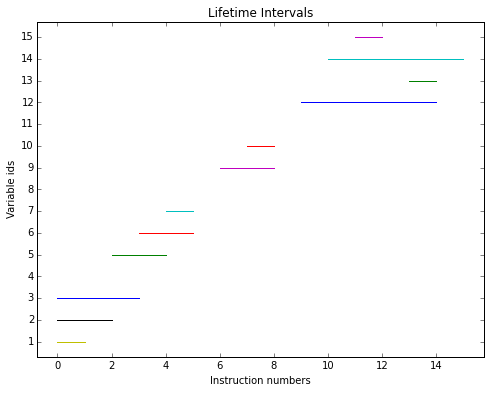

In [4]:
bls = BasicLinearScan(gcd)
intervals = bls.compute_intervals()
print IntervalsPrinter(intervals).full()
utils.draw_intervals(intervals, figsize=(8,6))

### Register allocation
Linear scan allocator takes as input the intervals and number of free registers. It processes the intervals in the order of their left endpoints and tries to allocate a free register to each variable. If at the given moment there are no free registers, an interval is chosen for spilling. On default, from all *active* intervals, it chooses the one with the furthest end but there are other strategies possible. <br><br>
The variable whose interval was spilled is assigned a memory slot. Furthermore we have to insert a store instruction after its definition as well as load instructions before all its uses. <br>

In the example below we try to allocate the variables only to 2 registers. As we can see, it ends with two variables spilled to memory.

In [5]:
bls.allocate_registers(intervals, 2)
print IntervalsPrinter(intervals).full()

INTERVAL   VAR-ID     REG  
[0, 1]     v1         reg2 
[0, 2]     v2         reg1 
[0, 3]     v3          -   
[2, 4]     v5         reg2 
[3, 5]     v6         reg1 
[4, 5]     v7         reg2 
[6, 8]     v9         reg1 
[7, 8]     v10        reg2 
[9, 14]    v12        reg1 
[10, 15]   v14         -   
[11, 12]   v15        reg2 
[13, 14]   v13        reg2 




### Spill code insertion
We already mentioned that we need to add store and load instructions in appropriate points of the program for all spilled variables. We do it at first for all instructions APART FROM phi instructions, with which we have to deal in different way. <br>
Here, we make a few important assumptions that make allocation a bit simpler and doesn't influence on final results.
<ul>
<li>All instructions, except for load and store, operate on regisers.</li>
<li>**Sratch registers**: If we load a spilled variable that will be used in a following instruction, we still need to load it to some regiser. Because of that we assume that we always have two so-called "sratch registers" that serve just for that. It is a common strategy in register allocation and if we assume it for all the allocations we do, it will not influence the results. We don't distinguish these registers and call both **reg0**. So if two *reg0*s overlap somewhere - it is OK. </li>
<li>Some of the variables (e.g. function arguments) are not defined in the function body. Nevertheless we still assume we can spill them.</li>
</ul>

### Translating out of SSA form (PHI elimination)
We use algorithm from *[4] Hack: 4.4 Implementing Phi-Operations: 55-58* to translate the program out of SSA form.
It boils down to inserting (definition, use) moves in a proper order and proper place in the CFG. We are not going to describe the algorithm again but there are a few points worth mentioning.
<ul>
<li>Sometimes it is necessary to add a new basic block.</li>
<li>It may happen that we need to use temporary variables (and scratch registers) which don't break anything.</li>
<li>If there is a move (def, use) which needs to be inserted but both variables reside in the same register or the same memory slot, we don't produce the move. </li>
<li>At the end we have to perform full function analysis again because nserting new instructions and variables breaks the initially computed liveness sets or loop information. </li>
</ul>

Below we can see a function listing after spill code insertion and phi elimination. There was a new basic block added (bb7). Moreover, there is no move between v12 and v9 because both were assigned the same register reg1. <br>

There may be some yellow (unallocated) variables left. These are definitions that are not used anywhere so they were skipped by the register allocator.

In [13]:
bls.insert_spill_code(intervals)
phi.eliminate_phi(gcd)
# OR bls.resolve()

gcd.perform_full_analysis()
print FunctionPrinter(gcd, Opts(alloc_only=True))

bb1(entry)
  0: reg0 = load mem(v3)    
  1: reg2 = icmp reg1 reg0 
  2: v4 = br reg2 bb3 bb2 


bb2(if.then)
  3: reg0 = load mem(v3)    
  4: reg2 = xor reg1 reg0 
  5: reg0 = load mem(v3)    
  6: reg1 = xor reg0 reg2 
  7: reg2 = xor reg2 reg1 
  8: v8 = br bb3                 


bb7(None)
  9: reg2 = mov reg1       
 10: reg1 = load mem(v3)    


bb3(if.end)
 11: v11 = br bb4                 
 12: store mem(v14) reg2 


bb4(while.cond)
 13: reg2 = icmp reg1 const 
 14: v16 = br reg2 bb6 bb5 


bb5(while.body)
 15: reg0 = load mem(v14)   
 16: reg2 = srem reg0 reg1 
 17: v17 = br bb4                 
 18: store mem(v14) reg1 
 19: reg1 = mov reg2       


bb6(while.end)
 20: reg0 = load mem(v14)   
 21: v18 = ret reg0       





# Cost of allocation

At the end we can calculate the cost of the register allocation which constitutes our final results. Cost is computed per each instruction separately and summed up at the end. In default cost calculator all the instructions have cost 1 at the beginning. It also multiplies the cost of each instruction by 10^d, where d is a loop-nesting level and doubles the cost if it operates on memory.

In [14]:
bcost = BasicCostCalculator()
print CostPrinter(gcd, bcost).full()
print "FINAL COST:", bcost.function_cost(gcd)

  LOOP     COST               INSTR             
   0       2.0      0: reg0 = load mem(v3)    
   0       1.0      1: reg2 = icmp reg1 reg0 
   0       1.0      2: v4 = br reg2 bb3 bb2 
   0       2.0      3: reg0 = load mem(v3)    
   0       1.0      4: reg2 = xor reg1 reg0 
   0       2.0      5: reg0 = load mem(v3)    
   0       1.0      6: reg1 = xor reg0 reg2 
   0       1.0      7: reg2 = xor reg2 reg1 
   0       1.0      8: v8 = br bb3                 
   0       1.0      9: reg2 = mov reg1       
   0       2.0     10: reg1 = load mem(v3)    
   0       1.0     11: v11 = br bb4                 
   0       2.0     12: store mem(v14) reg2 
   1       10.0    13: reg2 = icmp reg1 const 
   1       10.0    14: v16 = br reg2 bb6 bb5 
   1       20.0    15: reg0 = load mem(v14)   
   1       10.0    16: reg2 = srem reg0 reg1 
   1       10.0    17: v17 = br bb4                 
   1       20.0    18: store mem(v14) reg1 
   1       10.0    19: reg1 = mov reg2       
   0       2.

## Combined results
Now let's try to compute the cost of allocation for another register counts and cost calculators.

In [5]:
setting = utils.ResultCompSetting(
        functions = [gcd],
        regcounts = range(7),
        allocators = [("Basic linear scan", BasicLinearScan, {})],
        cost_calculators = [BasicCostCalculator(), SpillRatioCalculator()])

res = utils.compute_full_results(setting)
utils.print_result_table(res, setting)


+-----------------------+----------------------------+
|                       | Basic linear scan          |
+-----------+-----------+--------------+-------------+
| Functions | Registers | Default Cost | Spill Ratio |
+-----------+-----------+--------------+-------------+
| gcd       | 0         | 300.0        | 100         |
|           +-----------+--------------+-------------+
|           | 1         | 200.0        | 61          |
|           +-----------+--------------+-------------+
|           | 2         | 111.0        | 27          |
|           +-----------+--------------+-------------+
|           | 3         | 73.0         | 0           |
|           +-----------+--------------+-------------+
|           | 4         | 73.0         | 0           |
|           +-----------+--------------+-------------+
|           | 5         | 75.0         | 4           |
|           +-----------+--------------+-------------+
|           | 6         | 73.0         | 0           |
+---------

From the table above we can notice that 3 registers guarantee that no variable will be spilled. <br>
Small cost differences afterwards (like for 5 registers) are caused by moves that may or may NOT be inserted during phi elimination phase when two variables are or are NOT in the same registers or memory slots. 


## More spilling strategies, larger functions
Let's see how register allocation works with different spilling heuristics for larger files. Let's check it on Gilbert-Johnson-Keerthi (GJK) collision detection algorithm available here: https://github.com/kroitor/gjk.c 

+-----------------------+------------------------------+-----------------------------+-------------------------------+
|                       | Basic lscan (furthest first) | Basic lscan (current first) | Basic lscan (less used first) |
+-----------+-----------+------------------------------+-----------------------------+-------------------------------+
| Functions | Registers | Default Cost                 | Default Cost                | Default Cost                  |
+-----------+-----------+------------------------------+-----------------------------+-------------------------------+
| gjk       | 0         | 8815.0                       | 8815.0                      | 8815.0                        |
|           +-----------+------------------------------+-----------------------------+-------------------------------+
|           | 1         | 5458.0                       | 7602.0                      | 8494.0                        |
|           +-----------+-----------------------

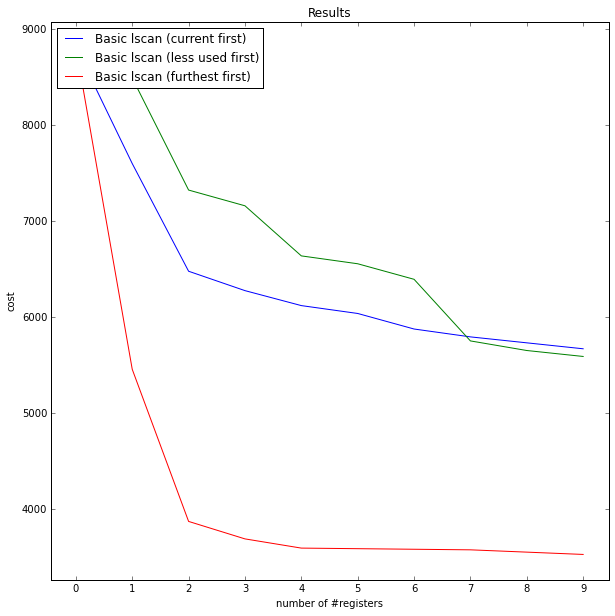

In [13]:
with open("programs/gjk.json") as f:
    module_json = json.load(f)

m = cfg.Module.from_json(module_json)
m.perform_full_analysis()

allocators = [
            ("Basic lscan (furthest first)", BasicLinearScan, {}),
            ("Basic lscan (current first)", BasicLinearScan, {"spilling_strategy": BasicLinearScan.SpillingStrategy.CURRENT_FIRST}),
            ("Basic lscan (less used first)", BasicLinearScan, {"spilling_strategy": BasicLinearScan.SpillingStrategy.LESS_USED_FIRST})]

setting = utils.ResultCompSetting(
        functions = [m.functions['gjk']],
        regcounts = range(10),
        allocators = allocators,
        cost_calculators = [BasicCostCalculator()])#, SpillRatioCalculator()])

res = utils.compute_full_results(setting)
utils.print_result_table(res, setting)
utils.plot_reg_algorithm(res, setting, figsize=(10,10))


## References
[1] K. Cooper, L. Torczon. Engineering a Compiler. Second Edition, 2012 <br>
[2] C. Wimmer and M. Franz. Linear Scan Register Allocation on SSA Form <br>
[3] C. Wimmer and H. Mossenbock. Optimized interval splitting in a linear scan register allocator. <br>
[4] S. Hack. Register Allocation for Programs in SSA Form, 2006.